New version of reconstruction script.

With tip loss of the original frame, without contour loss of the original frame.

With motion model loss, but the parameter is detached. 

In [1]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion

from mpl_toolkits.mplot3d import Axes3D


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        # self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        self.ref_catheter_contour = ref_catheter_contour
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        # self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        self.ref_catheter_centerline = ref_catheter_centerline
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0, l=0.2, r=0.01)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            construction_bezier = ConstructionBezier()
            construction_bezier.to(self.gpu_or_cpu)
            construction_bezier.loadRawImage(self.image_save_path_list[i])
            construction_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            construction_bezier.getCylinderMeshProjImg()
            construction_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour_m = self.contour_chamfer_loss(construction_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
             
            # motion_model_loss += loss_contour_m.to(self.gpu_or_cpu)
            
            loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(construction_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu)) 
            weight_m = torch.tensor([1.0, 1.0]).to(self.gpu_or_cpu)
            loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            motion_model_loss += loss_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0, 1.0, 1.0]).to(self.gpu_or_cpu)
        # weight = torch.tensor([1.0e-5, 1.0, 1.0e-6]).to(self.gpu_or_cpu)
        # loss = loss_contour.to(self.gpu_or_cpu) * weight[0] + loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        loss = loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        
        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)


        print("-----------------------------------------------------------------")
        print("loss_contour: ", loss_contour)
        # print("loss_tip: ", loss_tip)
        # print("loss_boundary: ", loss_boundary)
        print("loss_tip_distance: ", loss_tip_distance)
        # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        print("motion_model_loss: ", motion_model_loss)
        print("loss: ", loss)
        print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





d:\Programs\miniconda3\envs\catheter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Camera Intrinsics:
[[883.00220751   0.         320.        ]
 [  0.         883.00220751 240.        ]
 [  0.           0.           1.        ]]
Camera Extrinsics:
[[-1.00000000e+00 -1.22464680e-16  1.49975978e-32  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [2]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

In [3]:
def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [4]:

if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01 -2.39781477e-01  9.49010349e-01]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    
    # para_init = np.array([0.034, -0.003, 0.526, 0.13, -0.24, 0.6],
    #                  dtype=np.float32) #1
    para_init = np.array([0.034, -0.01, 0.536, 0.2, -0.37, 0.6],
                     dtype=np.float32)

    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = read_gt_params(cc_specs_path)
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/'
    image_save_path_list = [
    folder_path + 'gt_5_0.0006_-0.0008_0.2_0.01.png',
    folder_path + 'gt_4_0.0006_-0.0006_0.2_0.01.png',
    folder_path + 'gt_3_0.0006_-0.0004_0.2_0.01.png',
    folder_path + 'gt_2_0.0006_-0.0002_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0, -0.0002], [0, -0.0002], [0, -0.0002], [0, -0.0002]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_new3/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        print("Gradients BEFORE BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
            else:
                print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        print("Gradients AFTER BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
            else:
                print(f"{name}: No gradient computed")
                
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        for name, param in catheter_optimize_model.named_parameters():
            print(f"Parameter: {name}, Updated Value: {param.data}")


        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        print("Loss: ", loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    for name, param in catheter_optimize_model.named_parameters():
        param_numpy = param.data.cpu().numpy()
        filename = f"{name}.npy"
        np.save(filename, param_numpy)
        print(f"Saved {name} to {filename}")

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:20,  1.42s/it, loss=6.33e+7]

-----------------------------------------------------------------
loss_contour:  tensor(69079267.4932, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61674.5805, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63209808., device='cuda:0')
loss:  tensor(63271482.5805, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 630522.5625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1900, -0.3600,  0.6100], device='cuda:0')
Loss:  63271482.58048279

loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:02<02:07,  1.30s/it, loss=6.31e+7]

-----------------------------------------------------------------
loss_contour:  tensor(79397079.9778, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(51882.6777, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63004216., device='cuda:0')
loss:  tensor(63056098.6777, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 559769.5
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1801, -0.3500,  0.6199], device='cuda:0')
Loss:  63056098.67774537

loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:03<02:08,  1.32s/it, loss=6.29e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.5692e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(43325.6750, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62824800., device='cuda:0')
loss:  tensor(62868125.6750, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 495710.8125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1703, -0.3401,  0.6297], device='cuda:0')
Loss:  62868125.6749653

loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:05<02:03,  1.28s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(76660301.1195, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(35914.3877, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62677336., device='cuda:0')
loss:  tensor(62713250.3877, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 437903.53125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1607, -0.3303,  0.6394], device='cuda:0')
Loss:  62713250.3877361

loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:06<01:58,  1.25s/it, loss=6.26e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.1998e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(29556.2749, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62569368., device='cuda:0')
loss:  tensor(62598924.2749, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 385923.625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1514, -0.3206,  0.6488], device='cuda:0')
Loss:  62598924.27488843

loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:07<01:55,  1.23s/it, loss=6.25e+7]

-----------------------------------------------------------------
loss_contour:  tensor(80622435.4772, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(24156.3683, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62509816., device='cuda:0')
loss:  tensor(62533972.3683, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 339367.1875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1425, -0.3110,  0.6580], device='cuda:0')
Loss:  62533972.368262485

loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:08<01:57,  1.26s/it, loss=6.25e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58846600.9425, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(19618.3747, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62508380., device='cuda:0')
loss:  tensor(62527998.3747, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 297850.5
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1341, -0.3016,  0.6669], device='cuda:0')
Loss:  62527998.37468933

loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:10<01:55,  1.26s/it, loss=6.26e+7]

-----------------------------------------------------------------
loss_contour:  tensor(53113385.2987, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15845.7322, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62574088., device='cuda:0')
loss:  tensor(62589933.7322, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 261006.234375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1263, -0.2924,  0.6755], device='cuda:0')
Loss:  62589933.732151955

loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:11<01:54,  1.26s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(50752943.6441, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(12742.9848, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62712548., device='cuda:0')
loss:  tensor(62725290.9848, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 228478.796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1191, -0.2833,  0.6837], device='cuda:0')
Loss:  62725290.984764256

loop_id:  9


Optimizing:  10%|█         | 10/100 [00:12<01:56,  1.29s/it, loss=6.29e+7]

-----------------------------------------------------------------
loss_contour:  tensor(49860715.7940, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10217.3749, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62922792., device='cuda:0')
loss:  tensor(62933009.3749, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 199918.9375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1127, -0.2746,  0.6915], device='cuda:0')
Loss:  62933009.37487403

loop_id:  10


Optimizing:  11%|█         | 11/100 [00:14<01:58,  1.33s/it, loss=6.32e+7]

-----------------------------------------------------------------
loss_contour:  tensor(49840117.8890, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8180.6101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63193068., device='cuda:0')
loss:  tensor(63201248.6101, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 174978.875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1071, -0.2660,  0.6990], device='cuda:0')
Loss:  63201248.61014966

loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:15<01:58,  1.35s/it, loss=6.35e+7]

-----------------------------------------------------------------
loss_contour:  tensor(50407102.4318, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(6550.7120, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63496948., device='cuda:0')
loss:  tensor(63503498.7120, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 153309.796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1024, -0.2578,  0.7060], device='cuda:0')
Loss:  63503498.712012336

loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:16<01:58,  1.36s/it, loss=6.38e+7]

-----------------------------------------------------------------
loss_contour:  tensor(51341192.6034, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(5253.6402, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63791080., device='cuda:0')
loss:  tensor(63796333.6402, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 134562.390625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0986, -0.2498,  0.7126], device='cuda:0')
Loss:  63796333.64018553

loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:18<01:56,  1.35s/it, loss=6.4e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(52383799.2814, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(4224.5287, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(64016724., device='cuda:0')
loss:  tensor(64020948.5287, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 118391.9375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0956, -0.2422,  0.7188], device='cuda:0')
Loss:  64020948.52874366

loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:19<01:56,  1.37s/it, loss=6.41e+7]

-----------------------------------------------------------------
loss_contour:  tensor(53210657.9532, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3408.2487, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(64107168., device='cuda:0')
loss:  tensor(64110576.2487, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 104465.328125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0936, -0.2349,  0.7246], device='cuda:0')
Loss:  64110576.24873816

loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:21<01:56,  1.38s/it, loss=6.4e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(53506680.6553, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2759.3392, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(64000996., device='cuda:0')
loss:  tensor(64003755.3392, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 92469.9765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0924, -0.2280,  0.7300], device='cuda:0')
Loss:  64003755.33920201

loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:22<01:53,  1.37s/it, loss=6.37e+7]

-----------------------------------------------------------------
loss_contour:  tensor(53131020.1503, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2241.3456, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63657808., device='cuda:0')
loss:  tensor(63660049.3456, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 82122.1640625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0920, -0.2214,  0.7350], device='cuda:0')
Loss:  63660049.34556523

loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:23<01:50,  1.34s/it, loss=6.31e+7]

-----------------------------------------------------------------
loss_contour:  tensor(52220579.9305, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1825.7518, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(63070592., device='cuda:0')
loss:  tensor(63072417.7518, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 73173.5546875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0923, -0.2152,  0.7396], device='cuda:0')
Loss:  63072417.7517685

loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:25<01:47,  1.33s/it, loss=6.23e+7]

-----------------------------------------------------------------
loss_contour:  tensor(51108375.1943, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1490.7323, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62269132., device='cuda:0')
loss:  tensor(62270622.7323, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 65415.625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0933, -0.2094,  0.7438], device='cuda:0')
Loss:  62270622.73225128

loop_id:  19


Optimizing:  20%|██        | 20/100 [00:26<01:47,  1.35s/it, loss=6.13e+7]

-----------------------------------------------------------------
loss_contour:  tensor(50165843.6972, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1219.8662, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61312952., device='cuda:0')
loss:  tensor(61314171.8662, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 58681.375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0948, -0.2039,  0.7476], device='cuda:0')
Loss:  61314171.8661582

loop_id:  20


Optimizing:  21%|██        | 21/100 [00:27<01:46,  1.35s/it, loss=6.03e+7]

-----------------------------------------------------------------
loss_contour:  tensor(49740948.7770, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1000.9496, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(60276968., device='cuda:0')
loss:  tensor(60277968.9496, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 52845.05859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0968, -0.1989,  0.7511], device='cuda:0')
Loss:  60277968.94955091

loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:29<01:46,  1.36s/it, loss=5.92e+7]

-----------------------------------------------------------------
loss_contour:  tensor(50253335.4189, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(824.9643, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(59235924., device='cuda:0')
loss:  tensor(59236748.9643, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 47819.9296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0993, -0.1942,  0.7543], device='cuda:0')
Loss:  59236748.964314744

loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:30<01:46,  1.39s/it, loss=5.83e+7]

-----------------------------------------------------------------
loss_contour:  tensor(52593028.4593, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(685.2194, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(58252324., device='cuda:0')
loss:  tensor(58253009.2194, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 43554.05859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1021, -0.1899,  0.7571], device='cuda:0')
Loss:  58253009.21939186

loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:32<01:46,  1.39s/it, loss=5.74e+7]

-----------------------------------------------------------------
loss_contour:  tensor(60433769.6717, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(576.6607, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(57370320., device='cuda:0')
loss:  tensor(57370896.6607, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 40023.44921875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1052, -0.1861,  0.7597], device='cuda:0')
Loss:  57370896.660712786

loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:33<01:43,  1.38s/it, loss=5.66e+7]

-----------------------------------------------------------------
loss_contour:  tensor(2.5287e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(495.3290, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(56614436., device='cuda:0')
loss:  tensor(56614931.3290, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37221.55859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1085, -0.1826,  0.7620], device='cuda:0')
Loss:  56614931.32900246

loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:34<01:43,  1.40s/it, loss=5.6e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(76904173.3636, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(437.9472, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55993144., device='cuda:0')
loss:  tensor(55993581.9472, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35144.95703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1119, -0.1795,  0.7640], device='cuda:0')
Loss:  55993581.94715674

loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:36<01:40,  1.38s/it, loss=5.55e+7]

-----------------------------------------------------------------
loss_contour:  tensor(95917930.8649, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(401.6101, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55503144., device='cuda:0')
loss:  tensor(55503545.6101, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33776.61328125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1154, -0.1767,  0.7657], device='cuda:0')
Loss:  55503545.61012258

loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:37<01:38,  1.37s/it, loss=5.51e+7]

-----------------------------------------------------------------
loss_contour:  tensor(59716812.9498, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(383.5660, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55133772., device='cuda:0')
loss:  tensor(55134155.5660, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33071.54296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1189, -0.1743,  0.7673], device='cuda:0')
Loss:  55134155.566022635

loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:38<01:36,  1.36s/it, loss=5.49e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56901361.2589, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(381.0711, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54871036., device='cuda:0')
loss:  tensor(54871417.0711, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 32950.546875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1223, -0.1723,  0.7686], device='cuda:0')
Loss:  54871417.07110443

loop_id:  29


Optimizing:  30%|███       | 30/100 [00:40<01:37,  1.39s/it, loss=5.47e+7]

-----------------------------------------------------------------
loss_contour:  tensor(59359883.6840, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(391.3078, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54700216., device='cuda:0')
loss:  tensor(54700607.3078, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33304.84375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1257, -0.1706,  0.7697], device='cuda:0')
Loss:  54700607.30781806

loop_id:  30


Optimizing:  31%|███       | 31/100 [00:41<01:34,  1.37s/it, loss=5.46e+7]

-----------------------------------------------------------------
loss_contour:  tensor(67165046.1723, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(411.3616, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54607648., device='cuda:0')
loss:  tensor(54608059.3616, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 34008.6796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1289, -0.1692,  0.7707], device='cuda:0')
Loss:  54608059.361624956

loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:42<01:32,  1.36s/it, loss=5.46e+7]

-----------------------------------------------------------------
loss_contour:  tensor(89418250.0150, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(438.2404, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54581052., device='cuda:0')
loss:  tensor(54581490.2404, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 34933.5859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1319, -0.1681,  0.7715], device='cuda:0')
Loss:  54581490.24035427

loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:44<01:30,  1.36s/it, loss=5.46e+7]

-----------------------------------------------------------------
loss_contour:  tensor(3.4833e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(468.9380, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54610060., device='cuda:0')
loss:  tensor(54610528.9380, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35959.5703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1346, -0.1673,  0.7721], device='cuda:0')
Loss:  54610528.93796055

loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:45<01:29,  1.35s/it, loss=5.47e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.2831e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(500.5213, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54686016., device='cuda:0')
loss:  tensor(54686516.5213, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36981.296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1372, -0.1668,  0.7726], device='cuda:0')
Loss:  54686516.52134746

loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:46<01:26,  1.34s/it, loss=5.48e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.3141e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(530.2387, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54801256., device='cuda:0')
loss:  tensor(54801786.2387, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37910.5234375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1394, -0.1666,  0.7731], device='cuda:0')
Loss:  54801786.23868209

loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:48<01:26,  1.35s/it, loss=5.49e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.5173e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(555.6320, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(54948920., device='cuda:0')
loss:  tensor(54949475.6320, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 38676.1484375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1413, -0.1665,  0.7734], device='cuda:0')
Loss:  54949475.63195288

loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:49<01:27,  1.40s/it, loss=5.51e+7]

-----------------------------------------------------------------
loss_contour:  tensor(95893253.7869, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(574.6389, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55122740., device='cuda:0')
loss:  tensor(55123314.6389, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39223.03515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1429, -0.1667,  0.7736], device='cuda:0')
Loss:  55123314.63893221

loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:51<01:27,  1.40s/it, loss=5.53e+7]

-----------------------------------------------------------------
loss_contour:  tensor(89057517.4160, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(585.6841, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55317136., device='cuda:0')
loss:  tensor(55317721.6841, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39510.828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1441, -0.1671,  0.7738], device='cuda:0')
Loss:  55317721.684094585

loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:52<01:23,  1.37s/it, loss=5.55e+7]

-----------------------------------------------------------------
loss_contour:  tensor(89942461.0858, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(587.7326, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55527176., device='cuda:0')
loss:  tensor(55527763.7326, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39512.328125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1451, -0.1677,  0.7739], device='cuda:0')
Loss:  55527763.73257117

loop_id:  39


Optimizing:  40%|████      | 40/100 [00:53<01:20,  1.35s/it, loss=5.57e+7]

-----------------------------------------------------------------
loss_contour:  tensor(92708041.9575, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(580.3203, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55748776., device='cuda:0')
loss:  tensor(55749356.3203, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39212.37109375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1457, -0.1684,  0.7739], device='cuda:0')
Loss:  55749356.320349455

loop_id:  40


Optimizing:  41%|████      | 41/100 [00:55<01:19,  1.35s/it, loss=5.6e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(93604879.5810, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(563.5425, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55978664., device='cuda:0')
loss:  tensor(55979227.5425, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 38606.5078125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1460, -0.1693,  0.7739], device='cuda:0')
Loss:  55979227.54252259

loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:56<01:18,  1.35s/it, loss=5.62e+7]

-----------------------------------------------------------------
loss_contour:  tensor(91665539.3354, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(538.0091, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(56214436., device='cuda:0')
loss:  tensor(56214974.0091, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37699.796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1461, -0.1703,  0.7738], device='cuda:0')
Loss:  56214974.00905659

loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:57<01:16,  1.34s/it, loss=5.65e+7]

-----------------------------------------------------------------
loss_contour:  tensor(89270737.9468, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(504.7724, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(56454576., device='cuda:0')
loss:  tensor(56455080.7724, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36505.703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1458, -0.1714,  0.7737], device='cuda:0')
Loss:  56455080.77238755

loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:59<01:14,  1.33s/it, loss=5.67e+7]

-----------------------------------------------------------------
loss_contour:  tensor(89441944.1662, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(465.2308, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(56698312., device='cuda:0')
loss:  tensor(56698777.2308, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35044.9140625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1454, -0.1726,  0.7736], device='cuda:0')
Loss:  56698777.23082228

loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:00<01:13,  1.33s/it, loss=5.69e+7]

-----------------------------------------------------------------
loss_contour:  tensor(95823662.1897, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(421.0166, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(56945540., device='cuda:0')
loss:  tensor(56945961.0166, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33344.16015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1447, -0.1739,  0.7735], device='cuda:0')
Loss:  56945961.01664715

loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:01<01:13,  1.36s/it, loss=5.72e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.2390e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(373.8816, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(57196560., device='cuda:0')
loss:  tensor(57196933.8816, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 31435.138671875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1438, -0.1752,  0.7733], device='cuda:0')
Loss:  57196933.881558776

loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:03<01:12,  1.36s/it, loss=5.75e+7]

-----------------------------------------------------------------
loss_contour:  tensor(4.3837e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(325.5816, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(57452036., device='cuda:0')
loss:  tensor(57452361.5816, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 29353.3515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1428, -0.1766,  0.7731], device='cuda:0')
Loss:  57452361.581605785

loop_id:  47


Optimizing:  48%|████▊     | 48/100 [01:04<01:11,  1.37s/it, loss=5.77e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.1935e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(277.7769, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(57712700., device='cuda:0')
loss:  tensor(57712977.7769, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 27137.14453125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1417, -0.1780,  0.7729], device='cuda:0')
Loss:  57712977.77688238

loop_id:  48


Optimizing:  49%|████▉     | 49/100 [01:06<01:09,  1.36s/it, loss=5.8e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(1.2161e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(231.9437, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(57979164., device='cuda:0')
loss:  tensor(57979395.9437, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 24826.67578125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1405, -0.1795,  0.7726], device='cuda:0')
Loss:  57979395.94366115

loop_id:  49


Optimizing:  50%|█████     | 50/100 [01:07<01:07,  1.35s/it, loss=5.83e+7]

-----------------------------------------------------------------
loss_contour:  tensor(2.1585e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(189.3099, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(58251876., device='cuda:0')
loss:  tensor(58252065.3099, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 22463.09765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1393, -0.1809,  0.7724], device='cuda:0')
Loss:  58252065.309853934

loop_id:  50


Optimizing:  51%|█████     | 51/100 [01:08<01:05,  1.33s/it, loss=5.85e+7]

-----------------------------------------------------------------
loss_contour:  tensor(2.6517e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(150.8130, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(58530820., device='cuda:0')
loss:  tensor(58530970.8130, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 20087.849609375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1380, -0.1823,  0.7721], device='cuda:0')
Loss:  58530970.81298328

loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [01:09<01:03,  1.32s/it, loss=5.88e+7]

-----------------------------------------------------------------
loss_contour:  tensor(1.1309e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(117.0810, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(58815596., device='cuda:0')
loss:  tensor(58815713.0810, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17742.140625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1368, -0.1837,  0.7719], device='cuda:0')
Loss:  58815713.08101612

loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [01:11<01:02,  1.33s/it, loss=5.91e+7]

-----------------------------------------------------------------
loss_contour:  tensor(85396138.6152, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(88.4362, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(59105172., device='cuda:0')
loss:  tensor(59105260.4362, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 15466.8095703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1356, -0.1851,  0.7716], device='cuda:0')
Loss:  59105260.43622295

loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [01:12<01:04,  1.40s/it, loss=5.94e+7]

-----------------------------------------------------------------
loss_contour:  tensor(73671917.4906, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(64.9183, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(59398068., device='cuda:0')
loss:  tensor(59398132.9183, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13302.5556640625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1864,  0.7713], device='cuda:0')
Loss:  59398132.91829968

loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [01:14<01:01,  1.38s/it, loss=5.97e+7]

-----------------------------------------------------------------
loss_contour:  tensor(67294231.8085, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(46.3216, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(59692268., device='cuda:0')
loss:  tensor(59692314.3216, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11290.73828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1334, -0.1877,  0.7711], device='cuda:0')
Loss:  59692314.32161303

loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [01:15<00:59,  1.36s/it, loss=6e+7]   

-----------------------------------------------------------------
loss_contour:  tensor(63414160.4079, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(32.2455, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(59985384., device='cuda:0')
loss:  tensor(59985416.2455, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9475.0537109375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1325, -0.1890,  0.7708], device='cuda:0')
Loss:  59985416.245479144

loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [01:16<00:56,  1.32s/it, loss=6.03e+7]

-----------------------------------------------------------------
loss_contour:  tensor(60927660.3354, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(22.1489, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(60274600., device='cuda:0')
loss:  tensor(60274622.1489, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7903.669921875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1316, -0.1901,  0.7705], device='cuda:0')
Loss:  60274622.148940384

loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [01:18<00:54,  1.30s/it, loss=6.06e+7]

-----------------------------------------------------------------
loss_contour:  tensor(59307028.1616, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.4073, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(60556988., device='cuda:0')
loss:  tensor(60557003.4073, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6630.07177734375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1309, -0.1912,  0.7703], device='cuda:0')
Loss:  60557003.40727212

loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [01:19<00:53,  1.31s/it, loss=6.08e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58260357.8599, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(11.3644, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(60829576., device='cuda:0')
loss:  tensor(60829587.3644, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5706.51416015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1303, -0.1923,  0.7700], device='cuda:0')
Loss:  60829587.364429444

loop_id:  59


Optimizing:  60%|██████    | 60/100 [01:20<00:52,  1.31s/it, loss=6.11e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57606585.9770, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.3799, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61089576., device='cuda:0')
loss:  tensor(61089585.3799, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5161.49951171875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1299, -0.1932,  0.7697], device='cuda:0')
Loss:  61089585.379877314

loop_id:  60


Optimizing:  61%|██████    | 61/100 [01:21<00:50,  1.30s/it, loss=6.13e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57222469.3790, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.8654, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61334500., device='cuda:0')
loss:  tensor(61334508.8654, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4967.1474609375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1296, -0.1941,  0.7695], device='cuda:0')
Loss:  61334508.865404285

loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [01:23<00:48,  1.28s/it, loss=6.16e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57018182.4204, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.3106, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61562224., device='cuda:0')
loss:  tensor(61562233.3106, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5033.859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1294, -0.1949,  0.7693], device='cuda:0')
Loss:  61562233.31063539

loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [01:24<00:47,  1.28s/it, loss=6.18e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56926138.8618, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10.2992, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61771148., device='cuda:0')
loss:  tensor(61771158.2992, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5250.009765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1293, -0.1956,  0.7691], device='cuda:0')
Loss:  61771158.29917564

loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [01:25<00:45,  1.26s/it, loss=6.2e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(56896139.3912, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(11.5124, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61960180., device='cuda:0')
loss:  tensor(61960191.5124, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5523.603515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1294, -0.1963,  0.7688], device='cuda:0')
Loss:  61960191.51244149

loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [01:27<00:45,  1.29s/it, loss=6.21e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56893319.2598, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(12.7260, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62128768., device='cuda:0')
loss:  tensor(62128780.7260, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5795.83251953125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1295, -0.1968,  0.7687], device='cuda:0')
Loss:  62128780.726000205

loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [01:28<00:43,  1.28s/it, loss=6.23e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56896615.3362, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(13.7987, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62276800., device='cuda:0')
loss:  tensor(62276813.7987, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6035.6015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1297, -0.1973,  0.7685], device='cuda:0')
Loss:  62276813.798692286

loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [01:29<00:41,  1.27s/it, loss=6.24e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56896864.3973, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(14.6572, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62404580., device='cuda:0')
loss:  tensor(62404594.6572, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6230.15380859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1300, -0.1977,  0.7683], device='cuda:0')
Loss:  62404594.657234594

loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [01:30<00:40,  1.27s/it, loss=6.25e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56893992.8410, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.2786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62512732., device='cuda:0')
loss:  tensor(62512747.2786, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6377.47509765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1304, -0.1981,  0.7682], device='cuda:0')
Loss:  62512747.27858847

loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [01:32<00:39,  1.27s/it, loss=6.26e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56893734.7552, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.6731, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62602132., device='cuda:0')
loss:  tensor(62602147.6731, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6481.21630859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1308, -0.1983,  0.7681], device='cuda:0')
Loss:  62602147.67307842

loop_id:  69


Optimizing:  70%|███████   | 70/100 [01:33<00:37,  1.25s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56904455.9599, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.8685, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62673804., device='cuda:0')
loss:  tensor(62673819.8685, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6547.1982421875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1312, -0.1985,  0.7680], device='cuda:0')
Loss:  62673819.86854043

loop_id:  70


Optimizing:  71%|███████   | 71/100 [01:34<00:36,  1.24s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56934509.5814, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.8977, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62728876., device='cuda:0')
loss:  tensor(62728891.8977, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6581.16748046875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1317, -0.1986,  0.7680], device='cuda:0')
Loss:  62728891.8977299

loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [01:35<00:34,  1.25s/it, loss=6.28e+7]

-----------------------------------------------------------------
loss_contour:  tensor(56990444.6331, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.7889, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62768552., device='cuda:0')
loss:  tensor(62768567.7889, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6587.32275390625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1321, -0.1987,  0.7679], device='cuda:0')
Loss:  62768567.78891678

loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [01:37<00:34,  1.26s/it, loss=6.28e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57076035.0022, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.5620, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62793976., device='cuda:0')
loss:  tensor(62793991.5620, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6567.8798828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1325, -0.1987,  0.7679], device='cuda:0')
Loss:  62793991.5619545

loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [01:38<00:33,  1.28s/it, loss=6.28e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57191949.2554, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.2255, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62806344., device='cuda:0')
loss:  tensor(62806359.2255, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6522.7080078125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1987,  0.7679], device='cuda:0')
Loss:  62806359.22554926

loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [01:39<00:32,  1.29s/it, loss=6.28e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57335901.2577, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(14.7796, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62806756., device='cuda:0')
loss:  tensor(62806770.7796, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6449.876953125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1333, -0.1986,  0.7679], device='cuda:0')
Loss:  62806770.77956011

loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [01:41<00:32,  1.35s/it, loss=6.28e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57503102.2819, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(14.2176, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62796328., device='cuda:0')
loss:  tensor(62796342.2176, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6346.1015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1336, -0.1984,  0.7680], device='cuda:0')
Loss:  62796342.21759635

loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [01:42<00:30,  1.32s/it, loss=6.28e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57686892.0750, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(13.5321, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62776120., device='cuda:0')
loss:  tensor(62776133.5321, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6207.65625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1339, -0.1983,  0.7680], device='cuda:0')
Loss:  62776133.53207876

loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [01:43<00:28,  1.31s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(57879412.3850, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(12.7176, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62747216., device='cuda:0')
loss:  tensor(62747228.7176, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6030.86474609375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1341, -0.1981,  0.7681], device='cuda:0')
Loss:  62747228.71764177

loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [01:44<00:27,  1.31s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58072407.3190, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(11.7757, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62710668., device='cuda:0')
loss:  tensor(62710679.7757, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5812.92041015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1343, -0.1979,  0.7682], device='cuda:0')
Loss:  62710679.77569979

loop_id:  79


Optimizing:  80%|████████  | 80/100 [01:46<00:26,  1.32s/it, loss=6.27e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58257788.0757, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10.7168, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62667528., device='cuda:0')
loss:  tensor(62667538.7168, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5552.3154296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1344, -0.1976,  0.7683], device='cuda:0')
Loss:  62667538.716789044

loop_id:  80


Optimizing:  81%|████████  | 81/100 [01:47<00:25,  1.32s/it, loss=6.26e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58428427.0846, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.5610, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62618852., device='cuda:0')
loss:  tensor(62618861.5610, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5249.00146484375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1974,  0.7684], device='cuda:0')
Loss:  62618861.56101665

loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [01:49<00:25,  1.40s/it, loss=6.26e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58578555.8831, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.3383, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62565660., device='cuda:0')
loss:  tensor(62565668.3383, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4904.7158203125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1971,  0.7686], device='cuda:0')
Loss:  62565668.338252075

loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [01:50<00:23,  1.38s/it, loss=6.25e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58704129.3102, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(7.0853, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62508984., device='cuda:0')
loss:  tensor(62508991.0853, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4522.73779296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1968,  0.7687], device='cuda:0')
Loss:  62508991.08530193

loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [01:51<00:22,  1.38s/it, loss=6.24e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58802990.3180, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(5.8433, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62449856., device='cuda:0')
loss:  tensor(62449861.8433, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4107.84375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1344, -0.1965,  0.7688], device='cuda:0')
Loss:  62449861.84329473

loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [01:53<00:20,  1.39s/it, loss=6.24e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58874819.2819, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(4.6541, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62389208., device='cuda:0')
loss:  tensor(62389212.6541, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3666.0927734375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1344, -0.1962,  0.7689], device='cuda:0')
Loss:  62389212.65412318

loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [01:54<00:19,  1.36s/it, loss=6.23e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58921002.4548, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3.5569, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62328000., device='cuda:0')
loss:  tensor(62328003.5569, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3204.6044921875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1342, -0.1960,  0.7691], device='cuda:0')
Loss:  62328003.5569238

loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [01:55<00:17,  1.34s/it, loss=6.23e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58944232.8984, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2.5844, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62267092., device='cuda:0')
loss:  tensor(62267094.5844, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2731.074951171875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1341, -0.1957,  0.7692], device='cuda:0')
Loss:  62267094.584370606

loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [01:57<00:16,  1.34s/it, loss=6.22e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58948204.3033, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.7607, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62207276., device='cuda:0')
loss:  tensor(62207277.7607, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2253.690673828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1340, -0.1954,  0.7694], device='cuda:0')
Loss:  62207277.76070619

loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [01:58<00:14,  1.31s/it, loss=6.21e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58937146.3148, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.0998, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62149296., device='cuda:0')
loss:  tensor(62149297.0998, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1780.6273193359375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1338, -0.1952,  0.7695], device='cuda:0')
Loss:  62149297.09975549

loop_id:  89


Optimizing:  90%|█████████ | 90/100 [01:59<00:13,  1.32s/it, loss=6.21e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58915507.2416, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.6048, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62093788., device='cuda:0')
loss:  tensor(62093788.6048, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1319.9859619140625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1336, -0.1949,  0.7696], device='cuda:0')
Loss:  62093788.60478209

loop_id:  90


Optimizing:  91%|█████████ | 91/100 [02:01<00:11,  1.33s/it, loss=6.2e+7] 

-----------------------------------------------------------------
loss_contour:  tensor(58887618.3912, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2689, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62041296., device='cuda:0')
loss:  tensor(62041296.2689, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 879.6245727539062
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1335, -0.1947,  0.7697], device='cuda:0')
Loss:  62041296.26886508

loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [02:02<00:10,  1.34s/it, loss=6.2e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58857455.9007, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0764, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61992284., device='cuda:0')
loss:  tensor(61992284.0764, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 468.2500915527344
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1334, -0.1945,  0.7698], device='cuda:0')
Loss:  61992284.076440655

loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [02:03<00:09,  1.36s/it, loss=6.19e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58828499.4326, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0054, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61947112., device='cuda:0')
loss:  tensor(61947112.0054, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 121.18954467773438
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1332, -0.1943,  0.7699], device='cuda:0')
Loss:  61947112.005402945

loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [02:05<00:08,  1.36s/it, loss=6.19e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58803647.7796, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0295, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61906048., device='cuda:0')
loss:  tensor(61906048.0295, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 289.8707580566406
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1331, -0.1941,  0.7700], device='cuda:0')
Loss:  61906048.02949296

loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [02:06<00:06,  1.36s/it, loss=6.19e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58785176.0909, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1209, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61869324., device='cuda:0')
loss:  tensor(61869324.1209, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 589.1201171875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1330, -0.1940,  0.7701], device='cuda:0')
Loss:  61869324.12092345

loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [02:08<00:05,  1.35s/it, loss=6.18e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58774735.7649, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2527, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61837036., device='cuda:0')
loss:  tensor(61837036.2527, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 852.0348510742188
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1330, -0.1939,  0.7701], device='cuda:0')
Loss:  61837036.25268025

loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [02:09<00:04,  1.35s/it, loss=6.18e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58773387.6481, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.4005, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61809224., device='cuda:0')
loss:  tensor(61809224.4005, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1072.7896728515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1938,  0.7702], device='cuda:0')
Loss:  61809224.40049494

loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [02:10<00:02,  1.35s/it, loss=6.18e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58781666.0726, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.5443, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61785868., device='cuda:0')
loss:  tensor(61785868.5443, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1250.6156005859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1937,  0.7702], device='cuda:0')
Loss:  61785868.54429208

loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [02:12<00:01,  1.34s/it, loss=6.18e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58799658.5868, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.6691, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61766896., device='cuda:0')
loss:  tensor(61766896.6691, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1386.4412841796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1936,  0.7702], device='cuda:0')
Loss:  61766896.66905807

loop_id:  99


Optimizing: 100%|██████████| 100/100 [02:13<00:00,  1.33s/it, loss=6.18e+7]

-----------------------------------------------------------------
loss_contour:  tensor(58826958.1014, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.7649, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61752204., device='cuda:0')
loss:  tensor(61752204.7649, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1482.2271728515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1936,  0.7703], device='cuda:0')
Loss:  61752204.76494296
Saved para_init to para_init.npy


proj_end_effector_loss_history:  [351.2109920910515, 322.1263036306386, 294.36601354537254, 268.0089093149556, 243.13072569475798, 219.8015844459979, 198.08268318724652, 178.02096591108776, 159.6432570718571, 142.9501652607108, 127.91098584296817, 114.46145213421667, 102.50502607705772, 91.91875481819064, 82.56208255807859, 74.28780790958929, 66.95290233041193, 60.42767194753037, 54.60278841380672, 49.3936465186249, 44.74258711586024, 40.61931350349235, 37.01943791744279, 33.96058635498467, 31.474720092794254, 29.59551171175015, 28.34114050549562, 27.697148684883057, 27.606923205297356, 27.975268294093343, 28.68315271910808, 29.60541687821923, 30.624759935400235, 31.639258760726904, 32.5649714291682, 33.335625174335924, 33.901000935512975, 34.22525659764623, 34.28505712893107, 34.06817721740726, 33.57208729239241, 32.80271502761845, 31.773334340273554, 30.503469385713377, 29.01780995011333, 27.345257679254072, 25.517899826658507, 23.570188050886316, 21.5380436045542, 19.458152735402376

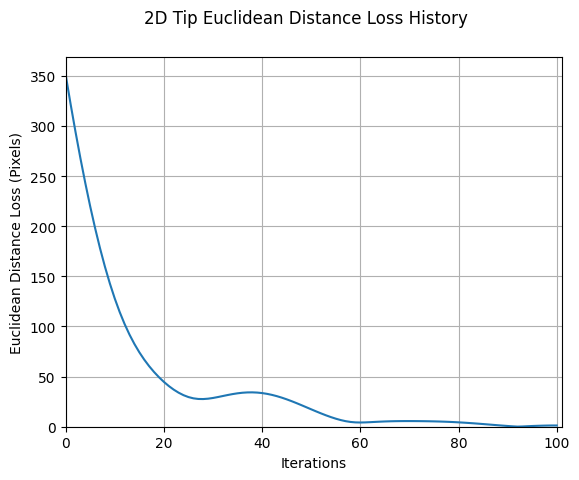

d3d_end_effector_loss_history:  [0.374146044254303, 0.36055800318717957, 0.34738194942474365, 0.33470451831817627, 0.3226074278354645, 0.3111630976200104, 0.3004293739795685, 0.2904455363750458, 0.2812286913394928, 0.272772878408432, 0.26505038142204285, 0.25801563262939453, 0.25161078572273254, 0.24577221274375916, 0.24043665826320648, 0.23554553091526031, 0.23104791343212128, 0.22690171003341675, 0.22307348251342773, 0.21953752636909485, 0.2162744700908661, 0.21326953172683716, 0.21051134169101715, 0.20799040794372559, 0.2056981474161148, 0.20362582802772522, 0.20176398754119873, 0.20010213553905487, 0.19862809777259827, 0.19732829928398132, 0.19618774950504303, 0.19519031047821045, 0.19431929290294647, 0.1935577392578125, 0.19288910925388336, 0.19229790568351746, 0.19177013635635376, 0.1912936568260193, 0.19085870683193207, 0.1904578059911728, 0.19008584320545197, 0.18974007666110992, 0.18941953778266907, 0.18912482261657715, 0.18885765969753265, 0.18862032890319824, 0.1884152740240

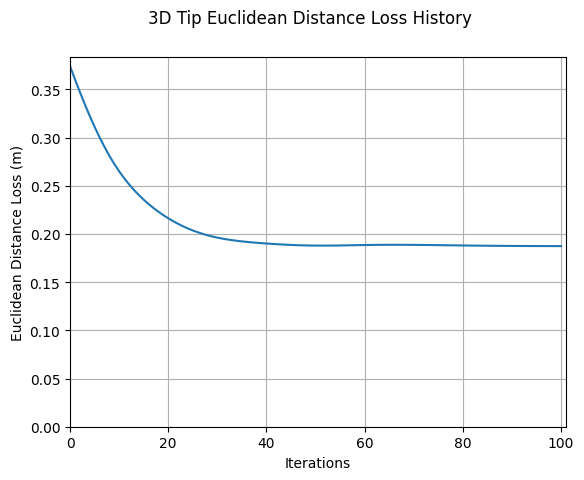

In [8]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.set_ylim(bottom=0)
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
ax2.set_ylim(bottom=0)
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()

In [6]:
p_start_np = p_start.numpy()
print(p_start_np)
result = catheter_optimize_model.para_init.data.cpu().numpy()
print("result: ", result)
control_points = np.vstack([p_start_np, result.reshape(2, 3)])
print("control_points: ", control_points)
control_points_gt = np.vstack([p_start_np, para_gt_np.reshape(2, 3)])
control_points_init = np.vstack([p_start_np, para_init.reshape(2, 3)])

[2.e-02 2.e-03 1.e-06]
result:  [ 0.034      -0.01        0.536       0.13291377 -0.19355388  0.7702713 ]
control_points:  [[ 2.0000000e-02  2.0000001e-03  1.0000000e-06]
 [ 3.4000002e-02 -9.9999998e-03  5.3600001e-01]
 [ 1.3291377e-01 -1.9355388e-01  7.7027130e-01]]


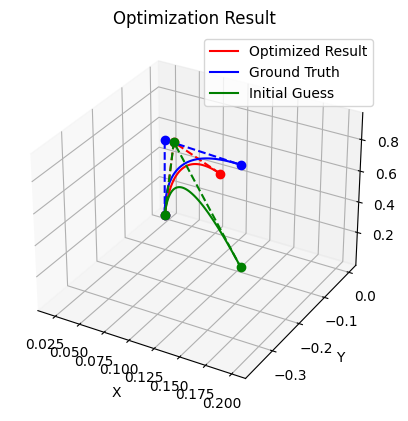

In [7]:
def bezier_curve_3d(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 3))

    for i in range(num_points):
        curve[i] = (1 - t[i]) ** 2 * control_points[0] + \
                   2 * (1 - t[i]) * t[i] * control_points[1] + \
                   t[i] ** 2 * control_points[2]

    return curve

# Generate the Bezier curve
curve = bezier_curve_3d(control_points)
curve_gt = bezier_curve_3d(control_points_gt)
curve_init = bezier_curve_3d(control_points_init)

# Plotting the Bezier curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制第一条贝塞尔曲线及其控制点
ax.plot(control_points[:, 0], control_points[:, 1], control_points[:, 2], 'ro--')
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], 'r-', label='Optimized Result')

# 绘制第二条贝塞尔曲线及其控制点
ax.plot(control_points_gt[:, 0], control_points_gt[:, 1], control_points_gt[:, 2], 'bo--')
ax.plot(curve_gt[:, 0], curve_gt[:, 1], curve_gt[:, 2], 'b-', label='Ground Truth')

ax.plot(control_points_init[:, 0], control_points_init[:, 1], control_points_init[:, 2], 'go--')
ax.plot(curve_init[:, 0], curve_init[:, 1], curve_init[:, 2], 'g-', label='Initial Guess')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Optimization Result')
ax.legend()

plt.savefig('Result.png')

plt.show()